In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(os.listdir())

cuda
['.config', 'sample_data']


In [2]:
NUM_EPOCHS = 2
LEARNING_RATE = 1e-3
BATCH_SIZE = 64

## Task 1

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [7]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])
transform_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    normalize
])

In [16]:
train_val_dataset = torchvision.datasets.ImageFolder('/kaggle/input/fer2013/train', transform=transform_train)
test_dataset = torchvision.datasets.ImageFolder('/kaggle/input/fer2013/test', transform=transform_val)

## Task 2

In [17]:
size_before_split = len(train_val_dataset)
val_size = int(0.2 * size_before_split)
train_size = size_before_split - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])
val_dataset.dataset.transform = transform_val

In [18]:
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Task 3

In [14]:
def show_images(dataset):
    images_per_label = 3
    label_to_images = {}
    for img, label in dataset:
        label = label.item() if torch.is_tensor(label) else label
        if label not in label_to_images:
            label_to_images[label] = []

        if len(label_to_images[label]) < images_per_label:
            label_to_images[label].append(img)

        if all(len(v) == images_per_label for v in label_to_images.values()):
            break

    all_images = []
    all_labels = []

    for label in sorted(label_to_images.keys()):
        all_images.extend(label_to_images[label])
        all_labels.extend([label] * images_per_label)

    images_tensor = torch.stack(all_images)

    grid = torchvision.utils.make_grid(images_tensor, nrow=images_per_label)
    grid = (grid - grid.min()) / (grid.max() - grid.min())
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()
    print("Labels order (row-wise):")
    print(all_labels)

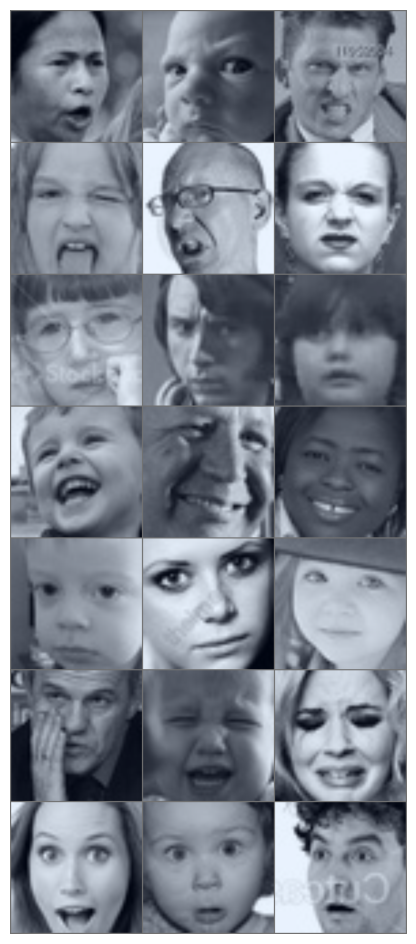

Labels order (row-wise):
[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]


In [15]:
show_images(train_dataset)

## Task 4

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(CustomCNN, self).__init__()

        # First convolutional block (in_channels -> 32)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.res1 = nn.Conv2d(in_channels, 32, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional block (32 -> 64)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.res2 = nn.Conv2d(32, 64, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # ----- First Residual Block -----
        residual1 = self.res1(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = out + residual1

        # ----- Second Residual Block -----
        residual2 = self.res2(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = out + residual2

        out = self.pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out


## Task 5

In [30]:
from tqdm import tqdm
os.makedirs("./models", exist_ok=True)
def train_model(model, train_loader, val_loader, optimizer=None, criterion=None):
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    # assuming model already in cuda device
    n_total_steps = len(train_loader)
    epochs = []
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_loss = 0.
        val_loss = 0.
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            batch_size = labels.size(0)
            outputs = model(images)
            loss = criterion(outputs, labels) # averaged over the batch
            train_loss += loss.item() * batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")
        train_loss /= len(train_loader.dataset)
        epochs.append(epoch + 1)
        train_losses.append(train_loss)
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                batch_size = labels.size(0)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * batch_size
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train loss {train_loss:.4f}, Val loss {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict()
            }, f"./models/Epoch{epoch+1}.pth")
            print("Saved best model")

    print("Finished training")
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Val Loss", marker="o")
    plt.legend()
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/2], Step [50/359], Loss: 1.7497
Epoch [1/2], Step [100/359], Loss: 1.8063
Epoch [1/2], Step [150/359], Loss: 1.7351
Epoch [1/2], Step [200/359], Loss: 1.6917
Epoch [1/2], Step [250/359], Loss: 1.7234
Epoch [1/2], Step [300/359], Loss: 1.7833
Epoch [1/2], Step [350/359], Loss: 1.8887


 50%|█████     | 1/2 [03:34<03:34, 214.85s/it]

Epoch [1/2], Train loss 1.7933, Val loss 1.7838
Saved best model
Epoch [2/2], Step [50/359], Loss: 1.7566
Epoch [2/2], Step [100/359], Loss: 1.8075
Epoch [2/2], Step [150/359], Loss: 1.8261
Epoch [2/2], Step [200/359], Loss: 1.7941
Epoch [2/2], Step [250/359], Loss: 1.6964
Epoch [2/2], Step [300/359], Loss: 1.7673
Epoch [2/2], Step [350/359], Loss: 1.8157


100%|██████████| 2/2 [06:02<00:00, 181.32s/it]

Epoch [2/2], Train loss 1.7838, Val loss 1.7796
Saved best model
Finished training


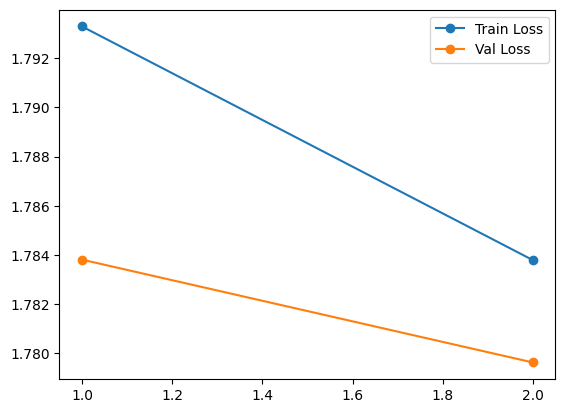

In [33]:
model = CustomCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
train_model(model, train_loader, val_loader, optimizer, criterion)

## Task 6

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
def evaluate_model(model, test_loader, class_names, criterion=None):
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    print('\033[1m' + 'Printing statistics...' + '\033[0m')
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    class_acc = cm.diagonal() / cm.sum(axis=1)
    for i, class_name in enumerate(class_names):
        print(f"Accuracy for class {class_name}: {class_acc[i]:.4f}")
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    return test_loss, acc, f1, cm, class_acc

Printing statistics...
Test Loss: 1.7850
Overall Accuracy: 0.2545
F1 Score (weighted): 0.1454
Accuracy for class 0: 0.0010
Accuracy for class 1: 0.0000
Accuracy for class 2: 0.0000
Accuracy for class 3: 0.9047
Accuracy for class 4: 0.0819
Accuracy for class 5: 0.0858
Accuracy for class 6: 0.0156


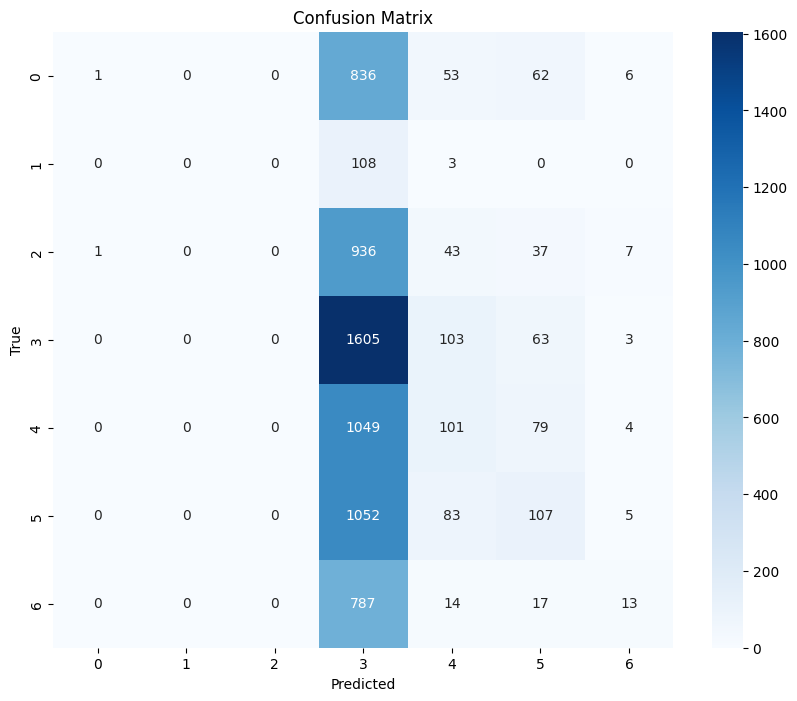

(1.7849738780553377,
 0.25452772359988857,
 0.1454301935264661,
 array([[   1,    0,    0,  836,   53,   62,    6],
        [   0,    0,    0,  108,    3,    0,    0],
        [   1,    0,    0,  936,   43,   37,    7],
        [   0,    0,    0, 1605,  103,   63,    3],
        [   0,    0,    0, 1049,  101,   79,    4],
        [   0,    0,    0, 1052,   83,  107,    5],
        [   0,    0,    0,  787,   14,   17,   13]]),
 array([0.00104384, 0.        , 0.        , 0.90473506, 0.08191403,
        0.08580593, 0.0156438 ]))

In [35]:
evaluate_model(model, test_loader, range(7))

## Task 7

ValueError: num must be an integer with 1 <= num <= 2, not 3

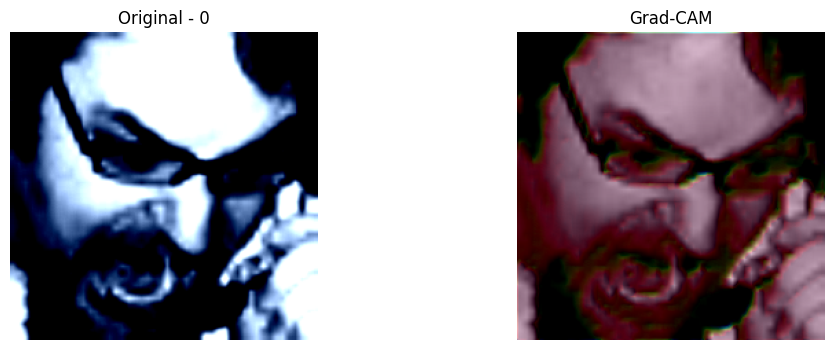

In [39]:
model.eval()
import cv2
num_classes = 7
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx):
        output = self.model(input_tensor)
        self.model.zero_grad()
        loss = output[:, class_idx]
        loss.backward()

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

target_layer = model.res2
gradcam = GradCAM(model, target_layer)

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    img = img.transpose(1, 2, 0)
    img = np.float32(img)
    overlay = heatmap + img
    overlay = overlay / np.max(overlay)
    return overlay

images_to_show = 1
plt.figure(figsize=(12, 4 * images_to_show))
for i, (image, label) in enumerate(test_loader):
    image = image.to(device)
    label = label.to(device)

    # take first image in batch
    if image.size(0) > 1:
        image = image[0].unsqueeze(0)
        label = label[0].unsqueeze(0)

    cam = gradcam.generate(image, label.item())
    img_np = image.squeeze().cpu().numpy()
    overlay = show_cam_on_image(img_np, cam)

    plt.subplot(images_to_show, 2, 2*i + 1)
    plt.imshow(img_np.transpose(1, 2, 0))
    plt.title(f"Original - {label.item()}")
    plt.axis('off')

    plt.subplot(images_to_show, 2, 2*i + 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Task 8

In [43]:
SAD_IDX = 5
HAPPY_IDX = 3
EPSILON = 0.01

mean = [0.4480, 0.4480, 0.4480]
std = [0.2526, 0.2526, 0.2526]
def _get_mean_std_tensors():
    """Return mean/std as (1,C,1,1) tensors on the current device.
    Falls back to ImageNet-like values if `mean`/`std` aren't available in scope.
    """
    try:
        mean_t = torch.tensor(mean, device=device).view(1, -1, 1, 1)
        std_t = torch.tensor(std, device=device).view(1, -1, 1, 1)
    except Exception:
        mean_t = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, -1, 1, 1)
        std_t = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, -1, 1, 1)
    return mean_t, std_t


def targeted_fgsm_attack(image, epsilon, target_label, model):
    """Targeted FGSM that correctly handles normalized inputs.

    - `image` should be the normalized tensor the model expects (1,C,H,W).
    - `epsilon` is in PIXEL space (0..1). Internally it's converted to the
      corresponding value in normalized space using the dataset `std`.
    - Returns the *normalized* perturbed image (detached, same device/dtype).
    """
    # Clone and ensure grad on the normalized tensor
    img = image.detach().clone().to(device)
    img.requires_grad = True

    model.eval()

    # Forward + targeted loss
    output = model(img)
    target = torch.tensor([target_label], dtype=torch.long, device=device)
    loss = torch.nn.functional.cross_entropy(output, target)

    # Backprop to get gradients w.r.t. the input
    if img.grad is not None:
        img.grad.zero_()
    model.zero_grad()
    loss.backward()

    if img.grad is None:
        # No gradient available -> return original image unchanged
        return image.detach()

    # Convert epsilon from pixel-space to normalized-space per-channel
    mean_t, std_t = _get_mean_std_tensors()
    eps_norm = (torch.tensor(epsilon, device=device) / std_t).to(device)

    # Targeted FGSM: move in the NEGATIVE direction of the gradient
    perturbed = img - eps_norm * img.grad.data.sign()

    # Clip in normalized space to keep pixels within [0,1]
    min_norm = (0.0 - mean_t) / std_t
    max_norm = (1.0 - mean_t) / std_t
    perturbed = torch.max(torch.min(perturbed, max_norm), min_norm)

    return perturbed.detach()


def evaluate_attack_success(model, test_loader, epsilon=EPSILON, debug=False):
    """Evaluate targeted FGSM success (SAD -> HAPPY).

    - `epsilon` is interpreted in pixel-space (0..1).
    - If `debug=True` a few before/after examples are shown.
    """
    # Ensure model params don't require grad (we only need input gradients)
    for param in model.parameters():
        param.requires_grad = False
    model.eval()

    correct_sads = 0
    fooled_to_happy = 0

    if debug:
        examples = []

    print(f"Starting targeted attack (Sad -> Happy) with epsilon={epsilon:.4f} (pixel-space)")

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Filter for American Sads
        mask = (labels == SAD_IDX)
        if not mask.any():
            continue

        sad_imgs = images[mask]

        for i in range(sad_imgs.size(0)):
            single_img = sad_imgs[i].unsqueeze(0)

            # STEP 1: original prediction
            with torch.no_grad():
                initial_pred = model(single_img).argmax(dim=1).item()

            if initial_pred != SAD_IDX:
                # skip misclassified sads
                continue

            correct_sads += 1

            # STEP 2: targeted attack (returns normalized tensor)
            adv_img = targeted_fgsm_attack(single_img, epsilon, HAPPY_IDX, model)

            # STEP 3: final prediction
            with torch.no_grad():
                final_pred = model(adv_img).argmax(dim=1).item()

            if final_pred == HAPPY_IDX:
                fooled_to_happy += 1

            if debug and len(examples) < 3:
                examples.append((single_img.cpu(), adv_img.cpu(), initial_pred, final_pred))

    if correct_sads == 0:
        print("No correctly classified Sad examples were found in the test set.")
        return 0.0

    sr = (fooled_to_happy / correct_sads) * 100.0
    print(f"Sads correctly classified: {correct_sads}")
    print(f"Successfully flipped to Happy:   {fooled_to_happy}")
    print(f"Attack Success Rate:           {sr:.2f}%")

    if debug and len(examples) > 0:
        import torchvision
        import matplotlib.pyplot as plt
        mean_t, std_t = _get_mean_std_tensors()
        for orig, adv, ipred, fpred in examples:
            # denormalize for display
            orig_denorm = orig * std_t.cpu() + mean_t.cpu()
            adv_denorm = adv * std_t.cpu() + mean_t.cpu()
            grid = torchvision.utils.make_grid(torch.cat([orig_denorm, adv_denorm], dim=0), nrow=2)
            plt.figure(figsize=(6,3))
            plt.imshow(grid.permute(1,2,0).clamp(0,1).numpy())
            plt.axis('off')
            plt.title(f"init:{ipred} -> adv:{fpred}")
            plt.show()

    return sr


--- Testing epsilon = 0.001
Starting targeted attack (Sad -> Happy) with epsilon=0.0010 (pixel-space)
Sads correctly classified: 107
Successfully flipped to Happy:   4
Attack Success Rate:           3.74%
Result: epsilon=0.0010 | attack success = 3.74%

--- Testing epsilon = 0.005
Starting targeted attack (Sad -> Happy) with epsilon=0.0050 (pixel-space)
Sads correctly classified: 107
Successfully flipped to Happy:   9
Attack Success Rate:           8.41%
Result: epsilon=0.0050 | attack success = 8.41%

--- Testing epsilon = 0.01
Starting targeted attack (Sad -> Happy) with epsilon=0.0100 (pixel-space)
Sads correctly classified: 107
Successfully flipped to Happy:   13
Attack Success Rate:           12.15%
Result: epsilon=0.0100 | attack success = 12.15%

--- Testing epsilon = 0.02
Starting targeted attack (Sad -> Happy) with epsilon=0.0200 (pixel-space)
Sads correctly classified: 107
Successfully flipped to Happy:   21
Attack Success Rate:           19.63%


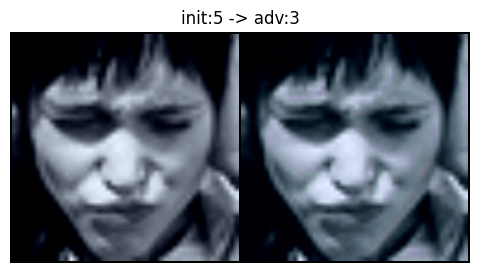

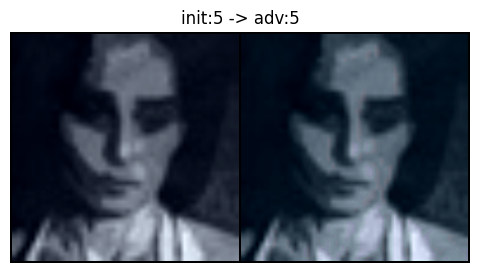

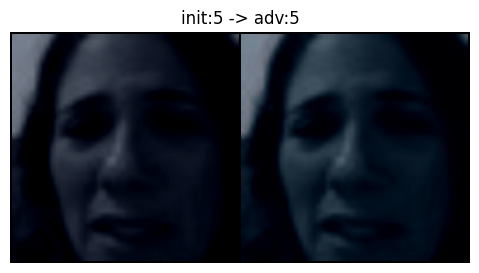

Result: epsilon=0.0200 | attack success = 19.63%


In [44]:
eps_values = [0.001, 0.005, 0.01, 0.02]
for eps in eps_values:
    print("\n--- Testing epsilon =", eps)
    sr = evaluate_attack_success(model, test_loader, epsilon=eps, debug=(eps == eps_values[-1]))
    print(f"Result: epsilon={eps:.4f} | attack success = {sr:.2f}%")